In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 11.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz

In [ ]:
# Load dataset
file_path = '825230133_DATABERSIH.xlsx'
df = pd.read_excel(file_path)

In [ ]:
# Tampilkan nama kolom
print(df.columns)

Index(['ETH_snapped_at', 'ETH_price', 'ETH_market_cap', 'ETH_total_volume',
       'DOGE_snapped_at', 'DOGE_price', 'DOGE_market_cap', 'DOGE_total_volume',
       'LITECOIN_snapped_at', 'LITECOIN_price', 'LITECOIN_market_cap',
       'LITECOIN_total_volume'],
      dtype='object')


In [ ]:
# Ambil kolom harga dan waktu
df_eth = df[['ETH_snapped_at', 'ETH_price']].copy()
df_doge = df[['DOGE_snapped_at', 'DOGE_price']].copy()
df_ltc = df[['LITECOIN_snapped_at', 'LITECOIN_price']].copy()

In [ ]:
# Ganti nama kolom agar konsisten
df_eth.columns = ['Tanggal', 'ETH_price']
df_doge.columns = ['Tanggal', 'DOGE_price']
df_ltc.columns = ['Tanggal', 'LITECOIN_price']

In [ ]:
# Gabungkan berdasarkan tanggal
merged_df = df_eth.merge(df_doge, on='Tanggal').merge(df_ltc, on='Tanggal')

In [ ]:
# Konversi ke datetime dan urutkan
date_column = 'Tanggal'
merged_df[date_column] = pd.to_datetime(merged_df[date_column])
merged_df = merged_df.sort_values(date_column)

In [ ]:
# Hitung return harian
merged_df['ETH_return'] = merged_df['ETH_price'].pct_change()
merged_df['DOGE_return'] = merged_df['DOGE_price'].pct_change()
merged_df['LITECOIN_return'] = merged_df['LITECOIN_price'].pct_change()

In [ ]:
# Hapus nilai NaN dari return
returns_df = merged_df.dropna(subset=['ETH_return', 'DOGE_return', 'LITECOIN_return'])

In [ ]:
# Fungsi hapus outlier (IQR)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

returns_df = remove_outliers(returns_df, 'ETH_return')
returns_df = remove_outliers(returns_df, 'DOGE_return')
returns_df = remove_outliers(returns_df, 'LITECOIN_return')

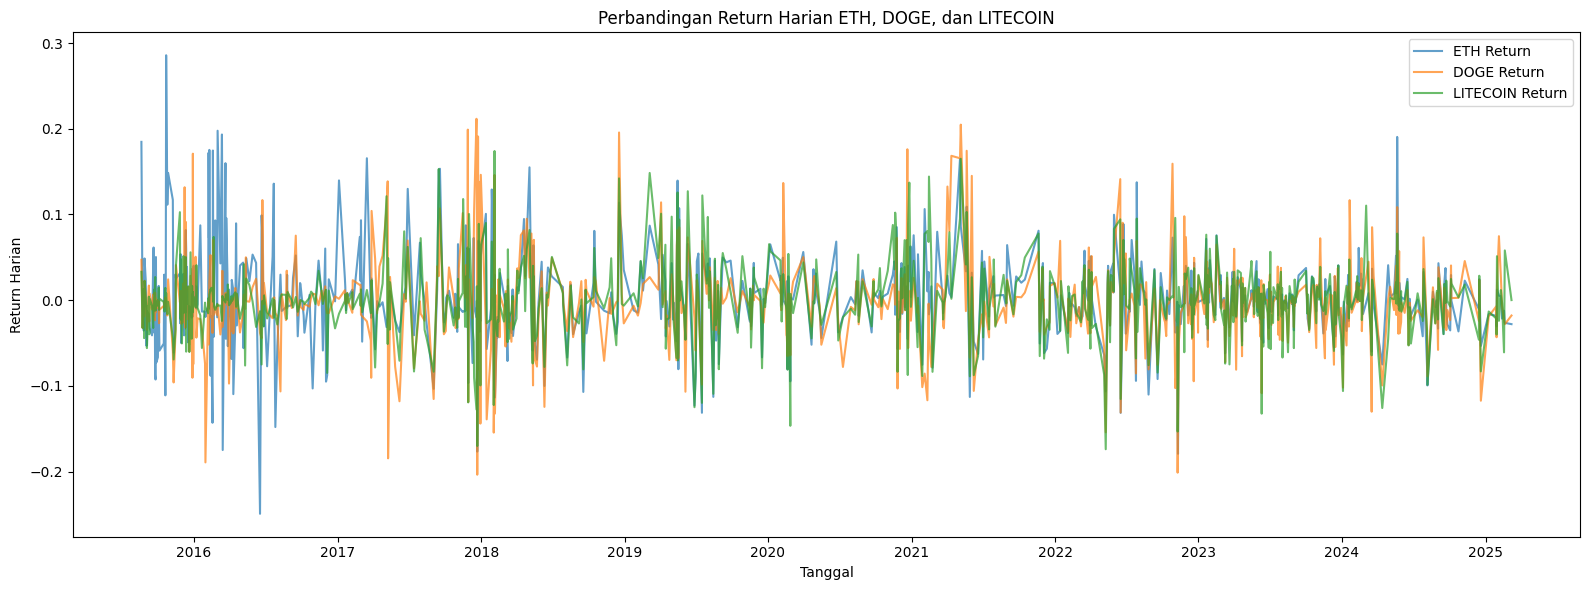

In [ ]:
# Visualisasi return harian
plt.figure(figsize=(16,6))
plt.plot(returns_df['Tanggal'], returns_df['ETH_return'], label='ETH Return', alpha=0.7)
plt.plot(returns_df['Tanggal'], returns_df['DOGE_return'], label='DOGE Return', alpha=0.7)
plt.plot(returns_df['Tanggal'], returns_df['LITECOIN_return'], label='LITECOIN Return', alpha=0.7)
plt.xlabel('Tanggal')
plt.ylabel('Return Harian')
plt.title('Perbandingan Return Harian ETH, DOGE, dan LITECOIN')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Statistik deskriptif
print(returns_df[['ETH_return', 'DOGE_return', 'LITECOIN_return']].describe())

       ETH_return  DOGE_return  LITECOIN_return
count  763.000000   763.000000       763.000000
mean     0.003127    -0.001731        -0.000302
std      0.051641     0.051018         0.044192
min     -0.249252    -0.203635        -0.173920
25%     -0.020125    -0.023391        -0.021306
50%      0.000948    -0.001774        -0.000794
75%      0.025308     0.018532         0.019412
max      0.285815     0.211667         0.174100


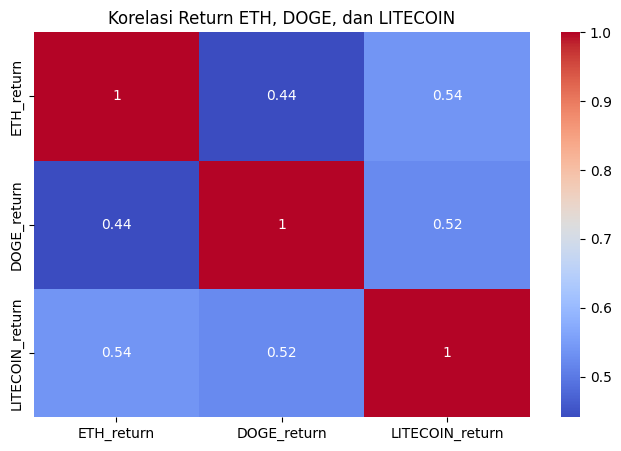

In [ ]:
# Korelasi antar return
correlation = returns_df[['ETH_return', 'DOGE_return', 'LITECOIN_return']].corr()
plt.figure(figsize=(8,5))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Korelasi Return ETH, DOGE, dan LITECOIN")
plt.show()

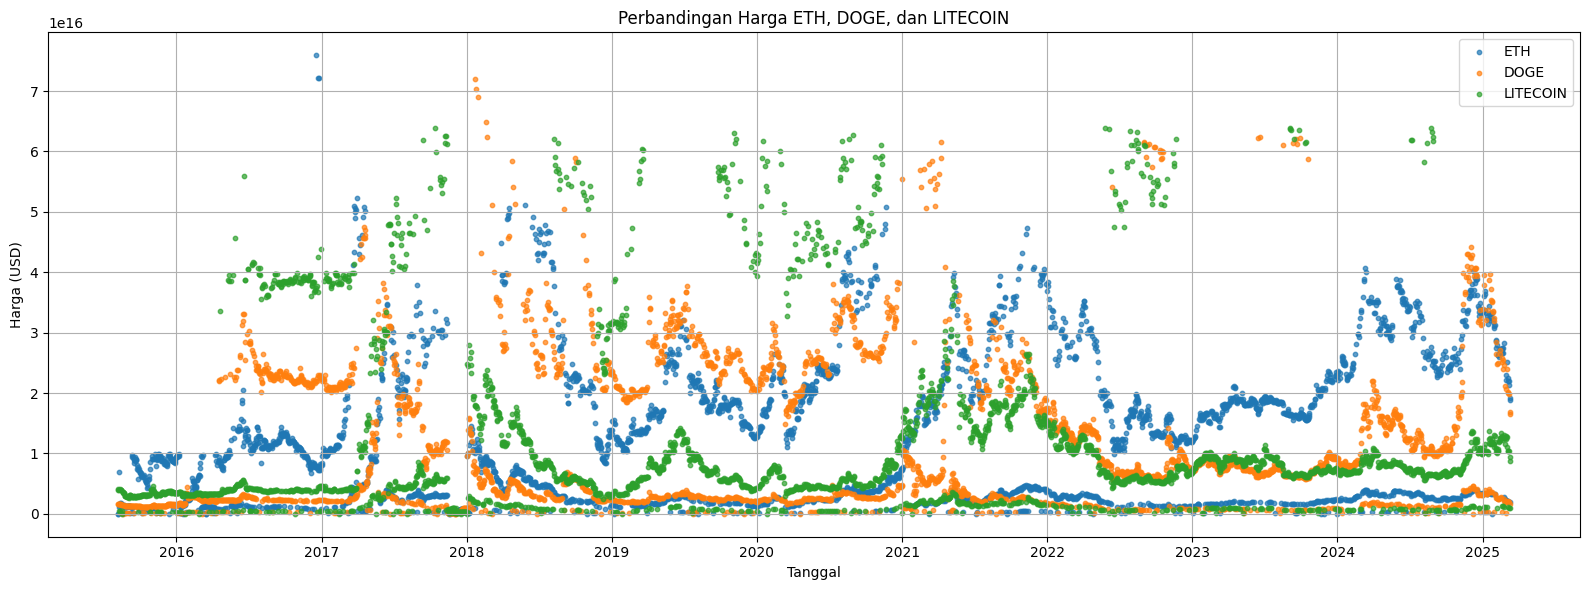

In [ ]:
# Visualisasi harga
plt.figure(figsize=(16,6))
plt.scatter(merged_df['Tanggal'], merged_df['ETH_price'], label='ETH', s=10, alpha=0.7)
plt.scatter(merged_df['Tanggal'], merged_df['DOGE_price'], label='DOGE', s=10, alpha=0.7)
plt.scatter(merged_df['Tanggal'], merged_df['LITECOIN_price'], label='LITECOIN', s=10, alpha=0.7)
plt.title("Perbandingan Harga ETH, DOGE, dan LITECOIN")
plt.xlabel("Tanggal")
plt.ylabel("Harga (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

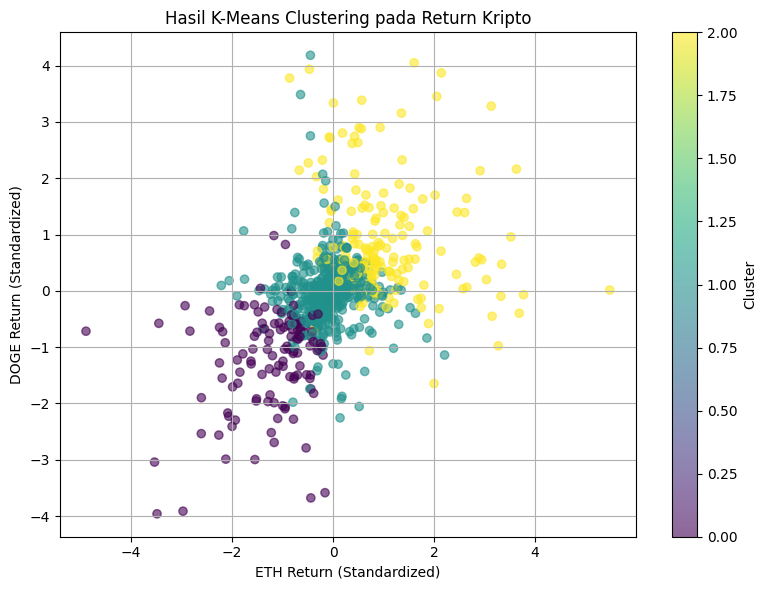

In [ ]:
# --- K-Means Clustering ---
X = returns_df[['ETH_return', 'DOGE_return', 'LITECOIN_return']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
returns_df['KMeans_Cluster'] = kmeans_labels

plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title('Hasil K-Means Clustering pada Return Kripto')
plt.xlabel('ETH Return (Standardized)')
plt.ylabel('DOGE Return (Standardized)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

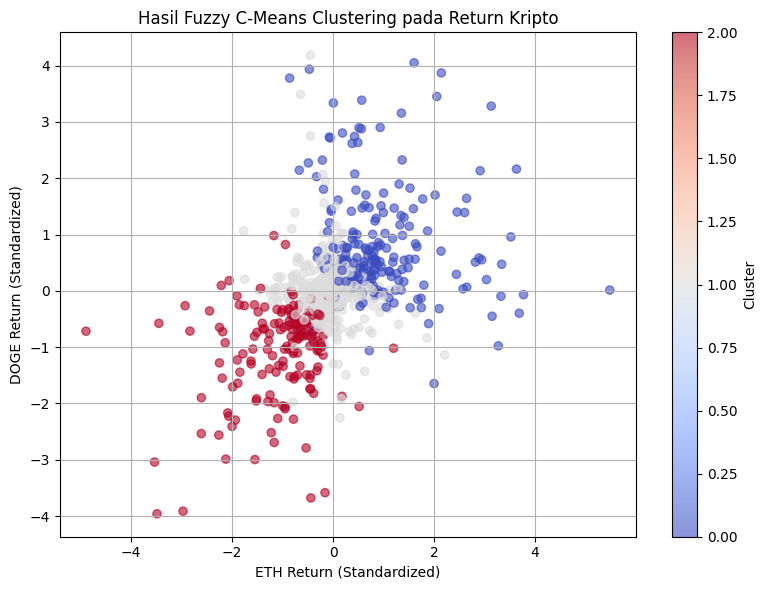

In [ ]:
# --- Fuzzy C-Means Clustering ---
X_fcm = X_scaled.T
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_fcm, c=3, m=2, error=0.005, maxiter=1000, init=None, seed=42
)
fcm_labels = np.argmax(u, axis=0)
returns_df['FCM_Cluster'] = fcm_labels

plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=fcm_labels, cmap='coolwarm', alpha=0.6)
plt.title('Hasil Fuzzy C-Means Clustering pada Return Kripto')
plt.xlabel('ETH Return (Standardized)')
plt.ylabel('DOGE Return (Standardized)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()